In [11]:
import torch
import numpy as np

# Fixar a semente do Torch para operações específicas
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Importa e plota tensor

In [12]:
import torch
import numpy as np
import cv2
import best.singular_point as sp
from teste_util import *
import teste_util as TS

# Fixar a semente do Torch para operações específicas
fixed_seed()

# leitura dos dados
trainloader,testloader =read_dataload_flower(sp.args.img_size,'./data/datasets')
iterator=iter(testloader)
img,labels = next(iterator)
print(img.shape,labels.shape)

# Carregar o modelo singular points
path_singular = './data/models/sp_map_fo_30.pth'
sp.args.num_channels = 1
model_single = sp.SingularPoints(args=sp.args).to(sp.device)
load_model(model_single,path_singular,sp.device)

#gerar variacao de transformacoes pespectivas e fotometrica
params_lists =AugmentationParamsGenerator(6,img.shape)

torch.Size([60, 1, 120, 120]) torch.Size([60])
Namespace(exported=False, num_channels=1, pyramid_levels=3, scale_pyramid=1.3, dim_first=3, dim_second=5, dim_third=8, group_size=36, epochs=70, border_size=12, box_size=21, nms_size=5, img_size=120, batch_size=16, path_data='./data', path_model='model.pt', is_loss_ssim=True, margin_loss=2.0, outlier_rejection=False, show_feature=False)
Model loaded from ./data/models/sp_map_fo_30.pth


In [13]:
import kornia
import torch.nn.functional as F

B,C,H,W = img.shape
mask = torch.ones(B,C,H,W)
border_size =20
mask[:, :, :border_size, :] = 0
mask[:, :, -border_size:, :] = 0
mask[:, :, :, :border_size] = 0
mask[:, :, :, -border_size:] = 0

bbox = torch.tensor([[
    [1., 1.],
    [2., 1.],
    [2., 2.],
    [1., 2.],
]]).expand(B, 1, -1, -1)

def generate_random_points(image_size, num_points, min_distance=10):
    # Extrair as dimensões da imagem
    H, W = image_size

    # Inicializar a lista de pontos válidos
    valid_points = []

    while len(valid_points) < num_points:
        # Gerar um tensor com coordenadas aleatórias
        random_coords = torch.rand(1, 2)
        random_coords[:, 0] *= W
        random_coords[:, 1] *= H

        # Se não houver pontos válidos, adicionar o primeiro ponto gerado
        if not valid_points:
            valid_points.append(random_coords)
        else:
            # Verificar a distância entre o ponto gerado e os pontos válidos existentes
            distances = F.pairwise_distance(random_coords, torch.cat(valid_points, dim=0))
            min_distance_check = distances >= min_distance

            # Se o ponto estiver afastado o suficiente dos pontos válidos existentes, adicioná-lo
            if min_distance_check.all():
                valid_points.append(random_coords)

    # Concatenar todos os pontos válidos e retorná-los como um tensor
    return torch.cat(valid_points, dim=0)

points = generate_random_points((H,W),50).expand(B, -1, -1)
shape = img.shape
params_lists =AugmentationParamsGenerator(6,shape)
next_item = next(params_lists)
points = points.to(sp.device)
mask = mask.to(sp.device)
bbox = bbox.to(sp.device)


In [14]:
def extract_features(model_single, x):
    features_key,features_key_summary,features_ori,features_ori_summary,max_coords_values, max_map= model_single(x)
    return features_key

In [15]:
from kornia.feature import laf_from_center_scale_ori
from kornia_moons.feature import visualize_LAF
import kornia
import matplotlib.pyplot as plt

def convert_points_to_lafs(points,img1, PS=19):
    orient = kornia.feature.LAFOrienter(PS)#kornia.feature.LAFOrienter(PS)PassLAF()
    sc =1 #np.random.randint(1, 6)
    scale_lafs = torch.ones(img1.shape[0],points.shape[1],1,1)*sc
    scale_lafs = scale_lafs.to(points.device)
    lafs1 = laf_from_center_scale_ori(points,scale_lafs)
    lafs2 = orient(lafs1, img1)
    return lafs1
    
def extract_patches_simple(batch, lafs, PS=19):
    # visualize_LAF(img1,lafs2,img_idx=0,figsize=(8,6))
    imgs_patches = kornia.feature.extract_patches_from_pyramid(batch, lafs, PS)
    # plot_patches_side_by_side(imgs_patches[0][0])#plota todas as features do patch 0 imagem 0
    imgs_patches =imgs_patches.reshape(-1,imgs_patches.shape[2],PS,PS)
    return imgs_patches
    
def extract_patches_from_keypoints(batch,filtered_points, PS=13):
    '''
    Extrai patches das imagens com base nos pontos de interesse filtrados.

    Parâmetros:
        batch (torch.Tensor): Tensor contendo as imagens com o formato B, C, H, W. <=out[0]
        pontos (torch.Tensor): Tensor contendo os pontos de interesse com o formato B, N, 2. <=out[3][0]
        mask (torch.Tensor): Tensor binário indicando os pontos a serem mantidos, com o formato B, N. <=out[1][0, 0]
        PS (int): Tamanho do patch a ser extraído.

    Retorna:
        patchs_mini_img (torch.Tensor): Tensor contendo os patches extraídos com o formato B, N_filtered, C, PS, PS.
    '''
    CH = 8  # TODO temporário enquanto não aplico a convolução
    B, _, H, W = batch.shape
    filtered_points = filtered_points.repeat(B, 1, 1)  # B, N(filtered), 2
    assert torch.allclose(filtered_points[0], filtered_points[1]), 'pontos devem ser iguais em todas as imagens'
    lafs = convert_points_to_lafs(filtered_points, batch)  # B, N(filtered), 2, 3

    # maps_activations = batch.repeat(1, CH, 1, 1)  # B, CH, H, W o repeat 8 é temporário enquanto não aplico a convolução
    maps_activations = extract_features(model_single,batch)
    # maps_activations[:, 2] = maps_activations[2, 2]
    patchs_mini_img_i = extract_patches_simple(batch, lafs, 32)
    patchs_mini_img_f = extract_patches_simple(maps_activations, lafs, PS)    
    return patchs_mini_img_i,patchs_mini_img_f



def plot_patches_side_by_side(imgs_patches):
    num_imgs = imgs_patches.shape[0]  # Número de imagens
    fig, axs = plt.subplots(1, num_imgs, figsize=(num_imgs*4, 4))

    axs = axs.reshape((1, num_imgs))  # Ajustar a forma para matriz 2D com uma única linha

    for i in range(num_imgs):
        axs[0, i].imshow(kornia.tensor_to_image(imgs_patches[i]))
        axs[0, i].axis('off')

    plt.show()
    
def plot_images_with_points_side_by_side(image1, image2, points1=None, points2=None):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Cria uma figura com duas subplots

    # Converte tensores para imagens
    image1 = kornia.utils.tensor_to_image(image1)
    image2 = kornia.utils.tensor_to_image(image2)

    # Plot da primeira imagem na subplot da esquerda
    axs[0].imshow(image1)
    if points1 is not None:
        points1 = points1.cpu().numpy()  # Converte para numpy
        keypoints_x = points1[:,0].flatten().tolist()
        keypoints_y = points1[:,1].flatten().tolist()
        axs[0].scatter(keypoints_x, keypoints_y, c='red', marker='x')  # Plota os pontos em vermelho com marcador 'x'
    axs[0].axis('off')  # Remove os eixos

    # Plot da segunda imagem na subplot da direita
    axs[1].imshow(image2)
    if points2 is not None:
        points2 = points2.cpu().numpy()  # Converte para numpy
        keypoints_x = points2[:,0].flatten().tolist()
        keypoints_y = points2[:,1].flatten().tolist()
        axs[1].scatter(keypoints_x, keypoints_y, c='red', marker='x')
    axs[1].axis('off')  # Remove os eixos

    plt.show()  # Mostra o plot com as duas imagens lado a lado

def plot_images_with_points_side_by_side(image1, image2, points1=None, points2=None):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Cria uma figura com duas subplots

    # Converte tensores para imagens
    image1 = kornia.utils.tensor_to_image(image1)
    image2 = kornia.utils.tensor_to_image(image2)

    # Plot da primeira imagem na subplot da esquerda
    axs[0].imshow(image1)
    if points1 is not None:
        points1 = points1.cpu().numpy()  # Converte para numpy
        keypoints_x = points1[:,0].flatten()
        keypoints_y = points1[:,1].flatten()
        axs[0].scatter(keypoints_x, keypoints_y, c='red', marker='x')  # Plota os pontos em vermelho com marcador 'x'
        
        # Adiciona os números dos labels aos pontos na subplot da esquerda
        for i, (x, y) in enumerate(zip(keypoints_x, keypoints_y)):
            axs[0].text(x, y, str(i), color='red')

    axs[0].axis('off')  # Remove os eixos

    # Plot da segunda imagem na subplot da direita
    axs[1].imshow(image2)
    if points2 is not None:
        points2 = points2.cpu().numpy()  # Converte para numpy
        keypoints_x = points2[:,0].flatten()
        keypoints_y = points2[:,1].flatten()
        axs[1].scatter(keypoints_x, keypoints_y, c='red', marker='x')
        
        # Adiciona os números dos labels aos pontos na subplot da direita
        for i, (x, y) in enumerate(zip(keypoints_x, keypoints_y)):
            axs[1].text(x, y, str(i), color='red')

    axs[1].axis('off')  # Remove os eixos

    plt.show()  # Mostra o plot com as duas imagens lado a lado


def filtrar_keypoints(lista_de_pontos, tensor_mascara):
    # Verificar se as coordenadas estão dentro das dimensões
    dimensao_max_x, dimensao_max_y = tensor_mascara.shape[1] - 1, tensor_mascara.shape[0] - 1
    pontos_filtrados = [
        1  if 0 <= p1[0] <= dimensao_max_x 
        and 0 <= p1[1] <= dimensao_max_y 
        and tensor_mascara[int(p1[1]), int(p1[0])] else 0 for p1 in lista_de_pontos
    ]
    pontos_filtrados = torch.tensor(pontos_filtrados, dtype=torch.bool)
    lista_de_pontos = torch.tensor(lista_de_pontos)
    return lista_de_pontos[pontos_filtrados],pontos_filtrados


dt aug torch.Size([60, 1, 120, 120]) torch.Size([60, 1, 120, 120]) torch.Size([60, 1, 4, 2]) torch.Size([60, 50, 2])


/tmp/ipykernel_95193/112018509.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lista_de_pontos = torch.tensor(lista_de_pontos)


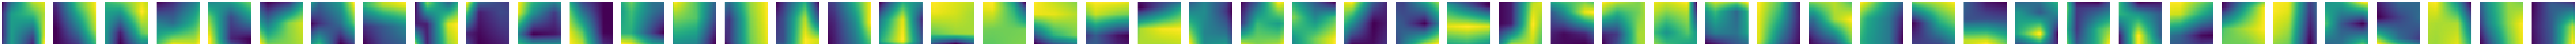

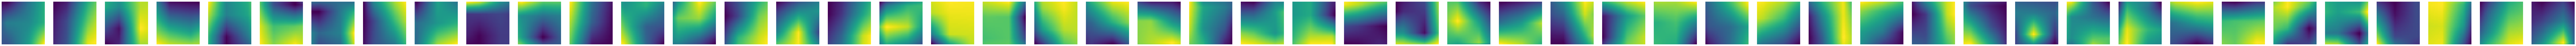

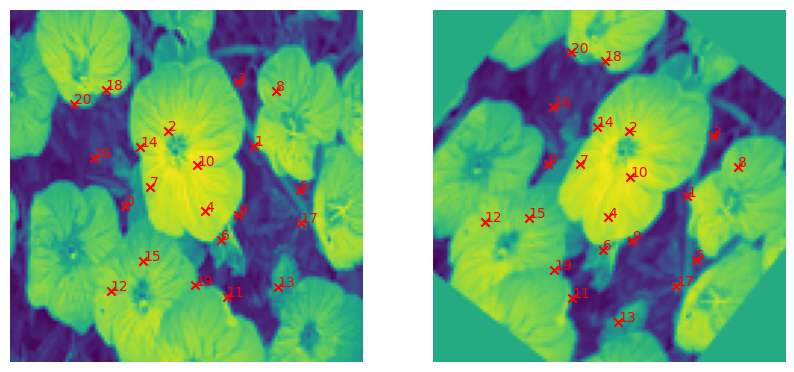

torch.Size([1260, 1, 32, 32]) torch.Size([1260, 8, 19, 19])


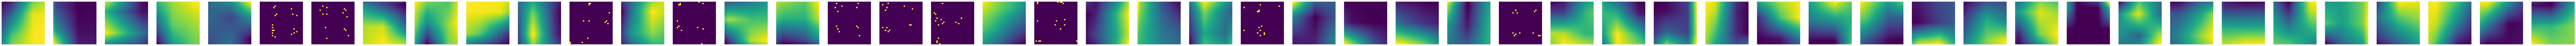

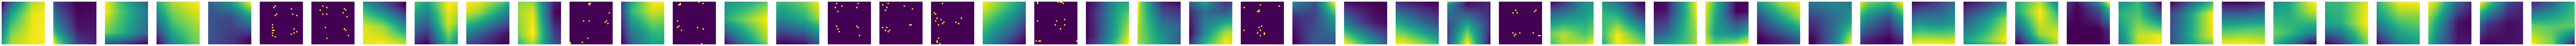

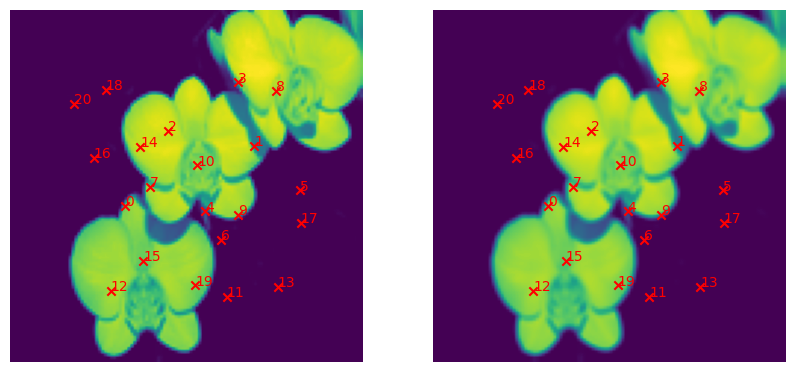

torch.Size([2520, 1, 32, 32]) torch.Size([2520, 8, 19, 19])


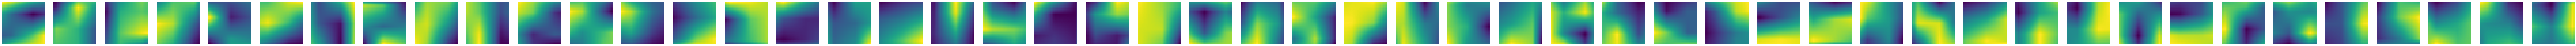

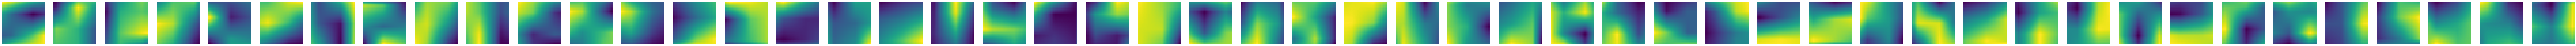

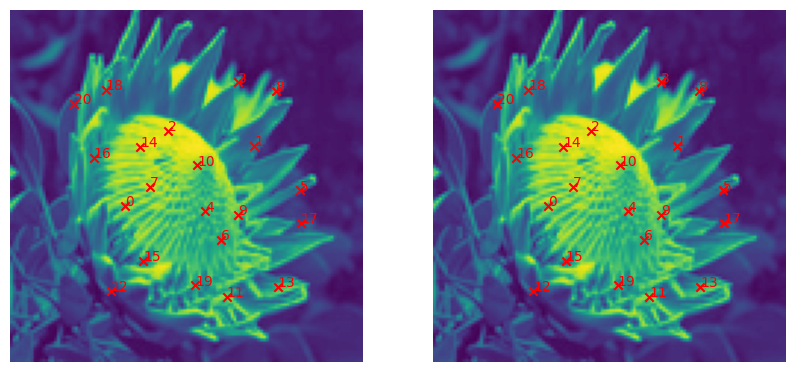

torch.Size([3780, 1, 32, 32]) torch.Size([3780, 8, 19, 19])


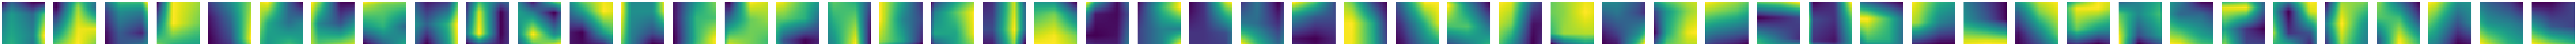

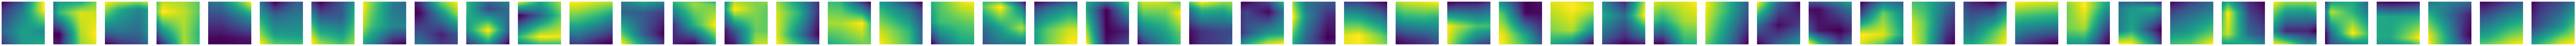

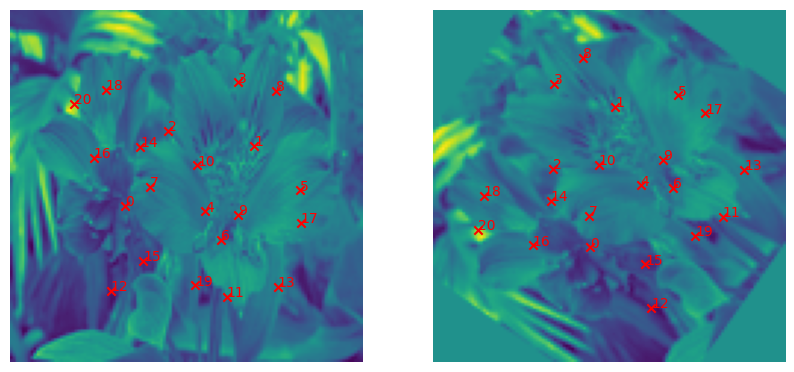

torch.Size([5040, 1, 32, 32]) torch.Size([5040, 8, 19, 19])


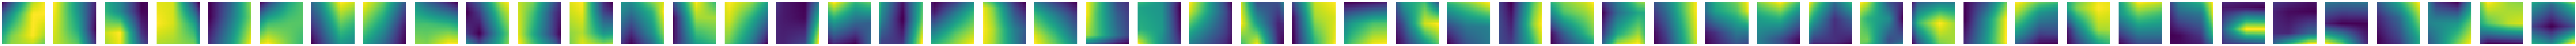

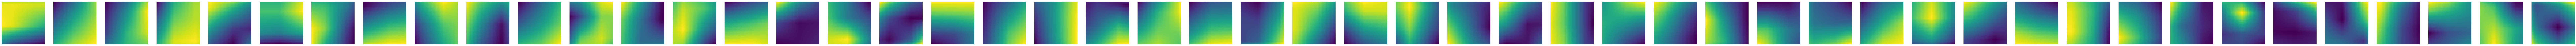

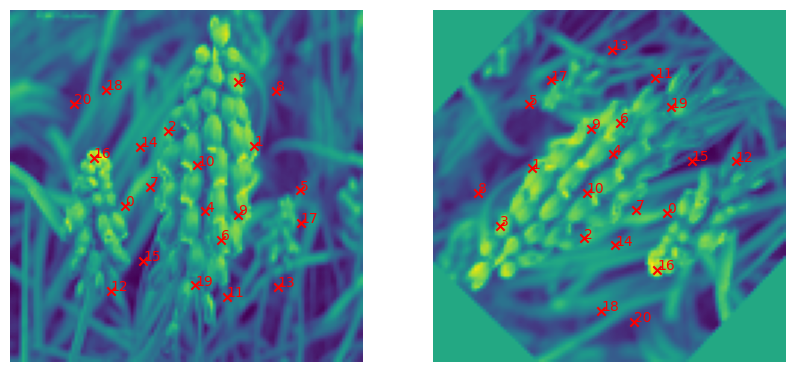

torch.Size([6300, 1, 32, 32]) torch.Size([6300, 8, 19, 19])


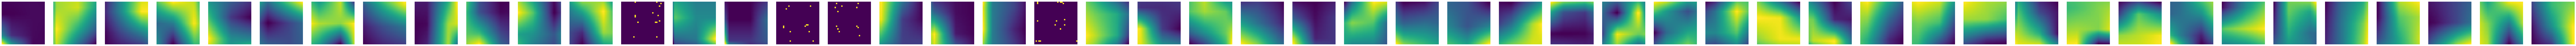

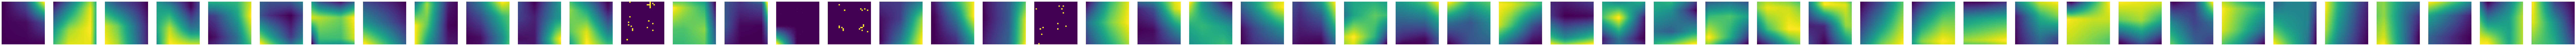

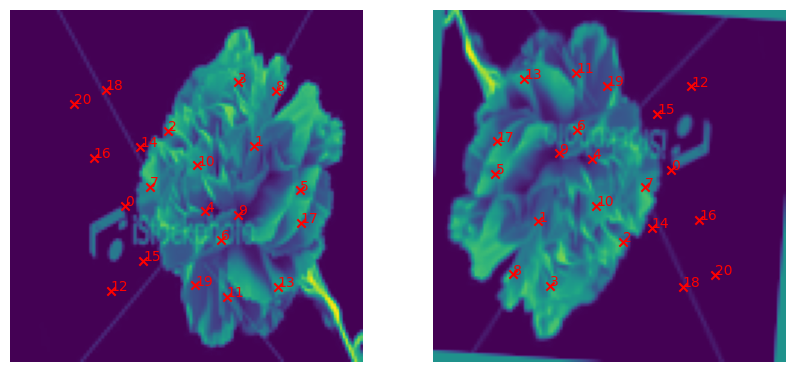

torch.Size([7560, 1, 32, 32]) torch.Size([7560, 8, 19, 19])


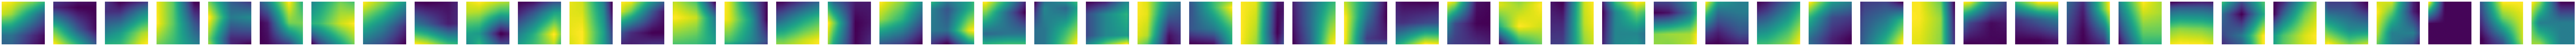

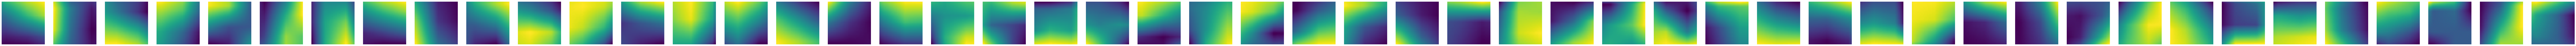

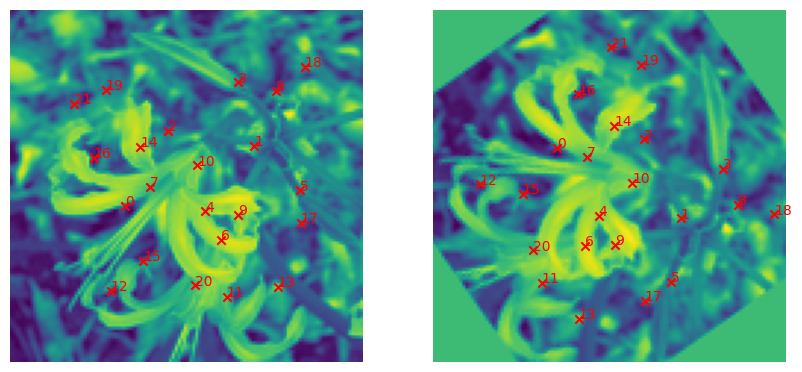

torch.Size([8880, 1, 32, 32]) torch.Size([8880, 8, 19, 19])


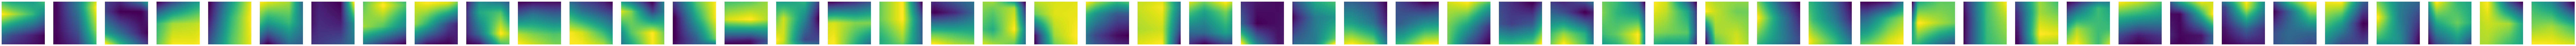

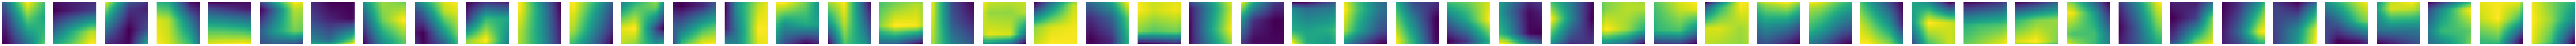

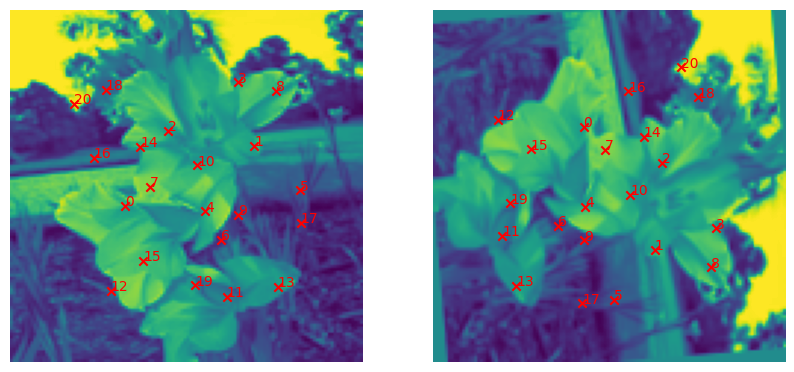

torch.Size([10140, 1, 32, 32]) torch.Size([10140, 8, 19, 19])


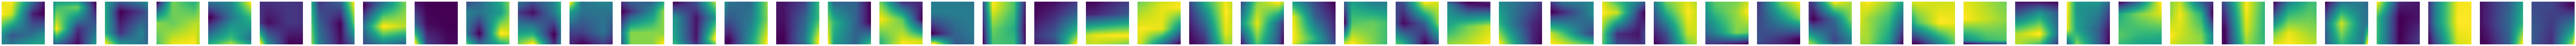

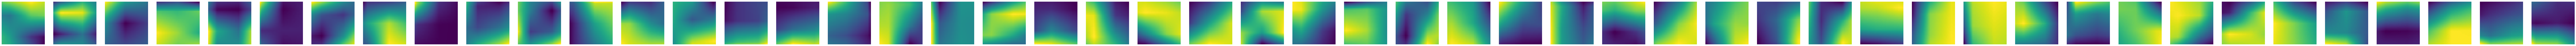

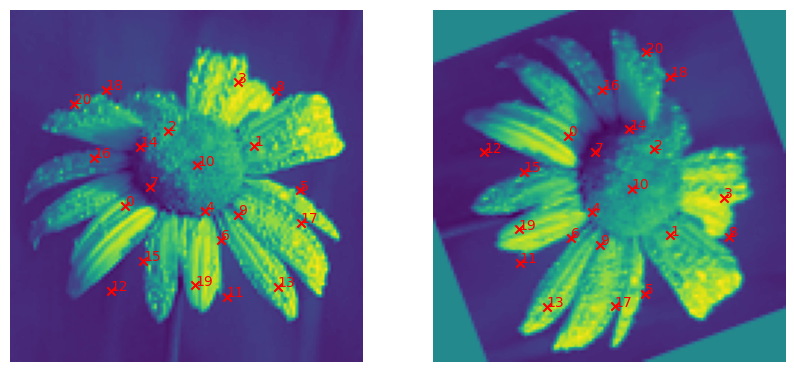

torch.Size([11400, 1, 32, 32]) torch.Size([11400, 8, 19, 19])


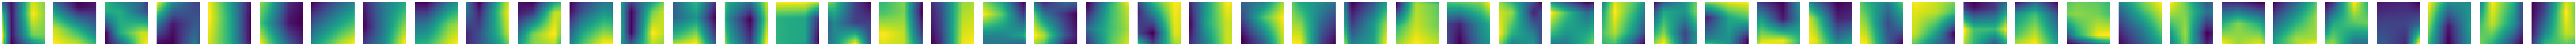

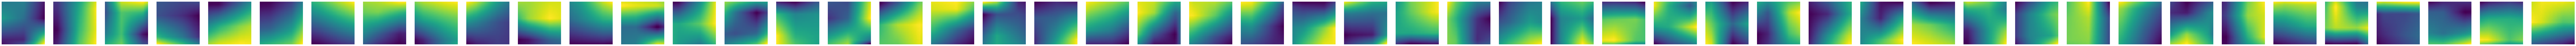

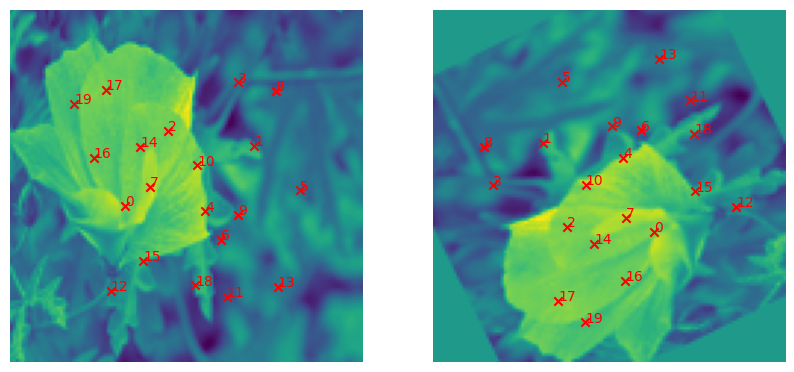

torch.Size([12600, 1, 32, 32]) torch.Size([12600, 8, 19, 19])


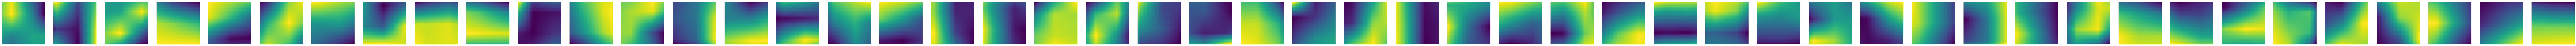

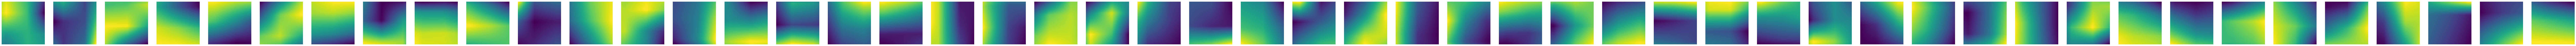

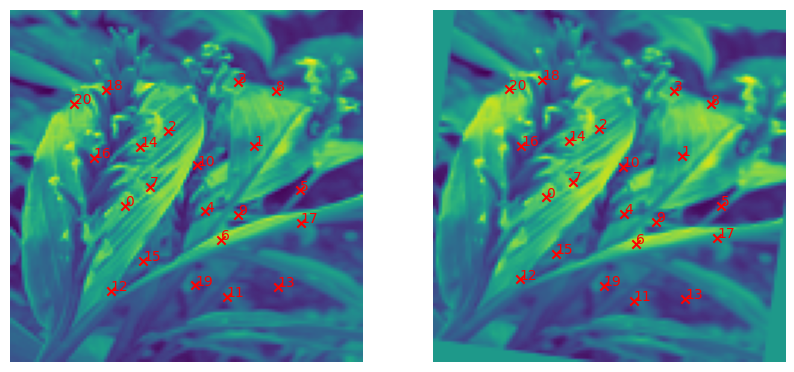

torch.Size([13860, 1, 32, 32]) torch.Size([13860, 8, 19, 19])


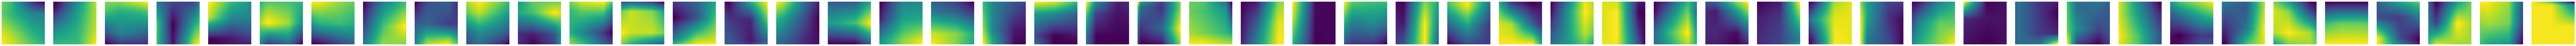

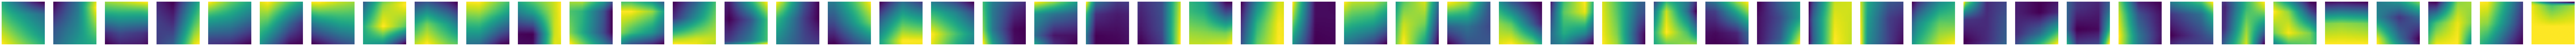

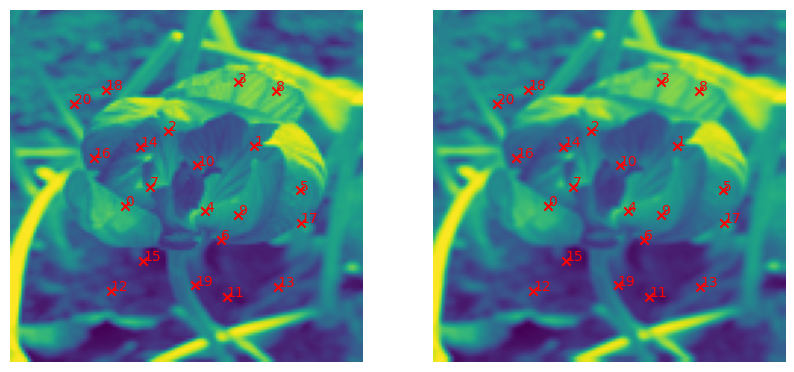

torch.Size([15120, 1, 32, 32]) torch.Size([15120, 8, 19, 19])


In [16]:
aug_list = kornia.augmentation.AugmentationSequential(
    kornia.augmentation.RandomAffine(degrees=360,p=0.8),
    kornia.augmentation.RandomBoxBlur((2,2),p=0.25),
    data_keys=["input", "mask", "bbox", "keypoints"],
    same_on_batch=True,
)

PS =19
print("dt aug",img.shape, mask.shape, bbox.shape, points.shape)
patchs_mini_src_i = torch.tensor([]).to(sp.device)      
patchs_mini_dst_i = torch.tensor([]).to(sp.device)  
patchs_mini_src_f = torch.tensor([]).to(sp.device)      
patchs_mini_dst_f = torch.tensor([]).to(sp.device)  
for input,labels in trainloader:
    input = input.to(sp.device)
    with torch.no_grad():
        out = aug_list(input, mask, bbox, points)
        #extrair patch da imagem original
        filtered_points,indices = filtrar_keypoints(out[3][0],out[1][0,0].bool())    
        
        patchs_mini_img1_i,patchs_mini_img1_f =extract_patches_from_keypoints(input, points[0][indices],PS=PS)
        patchs_mini_src_i = torch.cat((patchs_mini_src_i,patchs_mini_img1_i),dim=0)
        patchs_mini_src_f = torch.cat((patchs_mini_src_f,patchs_mini_img1_f),dim=0)
        plot_patches_side_by_side(patchs_mini_img1_i[:50,0])#plota todas os patch na feature map 0   
         
        #extrair patch da imagem transformada
        patchs_mini_img2_i,patchs_mini_img2_f  =extract_patches_from_keypoints(out[0], filtered_points,PS=PS)
        patchs_mini_dst_i = torch.cat((patchs_mini_dst_i,patchs_mini_img2_i),dim=0)    
        patchs_mini_dst_f = torch.cat((patchs_mini_dst_f,patchs_mini_img2_f),dim=0)    
        plot_patches_side_by_side(patchs_mini_img2_i[:50,0])#plota todas os patch na feature map 0    
        plot_images_with_points_side_by_side(input[0],out[0][0],points[0][indices],filtered_points)
        print(patchs_mini_src_i.shape,patchs_mini_src_f.shape)
        if patchs_mini_src_i.shape[0]>15000:
            break
        

In [17]:
from meu_dataset import MeuDataset

In [18]:
meu_dataset = MeuDataset(patchs_mini_src_f, patchs_mini_dst_f)
# Salvar o dataset em um arquivo chamado "meu_dataset.pt"
path_dataset = "./data/datasets/features_path_flowers_dataset.pt"
meu_dataset.save_to_file(path_dataset)
# Carregar o dataset do arquivo "meu_dataset.pt"
meu_dataset = MeuDataset.load_from_file(path_dataset)
#verificar se o objeto meu dataset está retornando o tensor correto
assert isinstance(meu_dataset,MeuDataset), 'o tipo de retorno não é MeuDataset'
assert isinstance(meu_dataset[0][0],torch.Tensor), 'o tipo de retorno não é torch.Tensor'
assert len(meu_dataset) == len(patchs_mini_src_f), 'o tamanho do dataset não é o esperado'

In [19]:
meu_dataset = MeuDataset(patchs_mini_src_i, patchs_mini_dst_i)
path_dataset = "./data/datasets/img_path_flowers_dataset.pt"
meu_dataset.save_to_file(path_dataset)
# Carregar o dataset do arquivo "meu_dataset.pt"
meu_dataset = MeuDataset.load_from_file(path_dataset)
#verificar se o objeto meu dataset está retornando o tensor correto
assert isinstance(meu_dataset,MeuDataset), 'o tipo de retorno não é MeuDataset'
assert isinstance(meu_dataset[0][0],torch.Tensor), 'o tipo de retorno não é torch.Tensor'
assert len(meu_dataset) == len(patchs_mini_src_i), 'o tamanho do dataset não é o esperado'

In [20]:
import gc
from torch.optim.lr_scheduler import ExponentialLR
gc.collect()
torch.cuda.empty_cache()
batch_size_siam = 100
from torch.utils.data import random_split, DataLoader
print(patchs_mini_src_f.shape, patchs_mini_src_i.shape)
train_dataset, val_dataset, test_dataset = random_split(meu_dataset, [0.3,0.5,0.2])

# Crie uma instância do DataLoader usando seu conjunto de dados personalizado
dataloader_train = DataLoader(train_dataset, batch_size=batch_size_siam, shuffle=True)
dataloader_val = DataLoader(val_dataset, batch_size=batch_size_siam, shuffle=True)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size_siam, shuffle=True)

torch.Size([15120, 8, 19, 19]) torch.Size([15120, 1, 32, 32])
